# Optimize denovo reference
    This script uses scripts provided by dDocent to de novo assembly in CD-HIT
    https://www.ddocent.com/assembly/
    
    Run dDocent first with basic commands. Use individuals retained from filtering to make assembly
    
## REDONE on 12/20/2022  

This is after most analyses. Want to be more strict about clustering simularity. Want to thoughtfully select individuals based off what is known

## For reference throughout this notebook:

**All unformatted text part of Trevor's original workflow.  Seth's annotations follow these rules**:  
+ *this text* = conceptual explanation of code<br>
+ <span style="color:purple">**this text**</span> = logical `code` explanation<br>
+ <span style="color:tomato">*this text*</span> = questions, uncertainties, parenthetical comments<br>
&nbsp;<br>

With that defined let's create a new section to talk about organization in this notebook...
<hr>
<hr>
    
## Sections:

1. Exploring file contents and formatting to run `RefOpt.sh`
2. Building slurm scripts to parallel run `RefOpt.sh`
3. Interpreting `RefOpt` output for determing optimal c parameter
4. Building slurm scripts to parallel run `MapOpt.sh`
5. Compare k parameters from `MapOpt` to create optimal assembly from full dataset

### 1.1 Import packages

In [2]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

*Just defining directory where we are working and checking with `pwd`*

In [32]:
root = "/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO"

In [33]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


In [34]:
pwd

'/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO'

### 1.2 Make assembly refopt dir and assign fastq dir

*directory itself is called 'assembly' while 'assembly_dir' is variable name presumably to avoid some variable/function confusion*

In [37]:
!mkdir assembly

mkdir: cannot create directory ‘assembly’: File exists


In [38]:
!mkdir assembly/refOpt

In [39]:
assembly_dir = os.path.join(root,'assembly')

In [40]:
refOpt_dir = os.path.join(assembly_dir,'refOpt')

In [41]:
fq_dir = '/data/gpfs/assoc/denovo/tfaske/rabbit/full/demult/fastq'

### 1.5 Sample random fastq for optimizer  

using pca_df.csv from old analyses, select individuals. Do it in R, easier for me.

Select 25 individuals. One of each variety / lineage combo + three each hololueca_grey & oreophila_green

*Idea here is to reduce the data we are initializing `RefOpt` and `MapOpt` on for efficiency purposes.  These test runs are just to determine optimal c, k1, and k2 parameters to build a final assembly for mapping.  Both scripts are huge alignment processes and would take way too long to run on full dataset.  Using 1 individual from eqach population with the most reads is a nice compromise. The final assembly will use **full** dataset.*

In [42]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


In [43]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
%%R 

setwd('/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO')

pca_df <- read.csv('data/pca_df.csv')

dim(pca_df)
#print(table(paste0(pca_df$Variety,'_',pca_df$Color))

[1] 585  24


In [46]:
%%R

pca_known <- pca_df[-which(is.na(pca_df$Ssp)),]
pca_known$Variety <- as.character(pca_known$Variety)
pca_known$Color <- as.character(pca_known$Color)
#dim(pca_known)
#table(pca_known$Variety)
pca_known$var_col <- as.character(paste0(pca_known$Variety,'_',pca_known$Color))
table(pca_known$var_col)


    arenaria_green    bigelovii_green   graveolens_green     hololueca_grey 
                 5                  9                 11                219 
  hololueca_hybrid       iridis_green      juncea_hybrid latisquamea_hybrid 
                30                  6                 11                  6 
 mohavensis_hybrid        nana_hybrid       nitida_green    oreophila_green 
                 5                  5                  6                 60 
    oreophila_grey   oreophila_hybrid  salicifolia_green   salicifolia_grey 
                 4                 17                  8                 18 
salicifolia_hybrid     speciosa_green      speciosa_grey    speciosa_hybrid 
                14                  3                 22                 34 
   turbinata_green 
                17 


In [50]:
%%R

#select individuals to keep
more <- c('hololueca_grey','oreophila_green')
keep_fq <- c()
for (vc in unique(pca_known$var_col)){
    #print(vc)
    df <- pca_known[which(pca_known$var_col == vc),]
    if (vc %in% more){
        keep_vc <- sample(df$All,3)
    }else{
        keep_vc <- sample(df$All,1)
    }
    keep_fq <- c(keep_fq,keep_vc)
}

In [56]:
%%R
#keep_fq
### mv keep_fq to refOpt

fq_dir <- '/data/gpfs/assoc/denovo/tfaske/rabbit/full/demult/fastq/'
refOpt_dir <- '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/refOpt/'

#cp_cmd <- array(NA,dim=length(keep_fq))
for (i in 1:length(keep_fq)){
    #cp_cmd[i] <- paste0('cp ',fq_dir,keep_fq[i],'.F.fq.gz ',refOpt_dir)
    cmd <- paste0('cp ',fq_dir,keep_fq[i],'.F.fq.gz ',refOpt_dir)
    system(cmd)
}
#cp_cmd

In [57]:
!ls {refOpt_dir}/*gz | wc -l 

25


# 2. Make a slurm script to run ReferenceOpt.sh   

ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors  
    
#### NOTE: must run dDocent to at least trim first 

### Understanding ReferenceOpt.sh (in process of transferring notes)

Much of the details can't be found here: http://www.ddocent.com/assembly/<br>
This script is written by Jon Puritz to determine what c parameter is optimal for reference assembly.  The steps below are repeatedly iteratively with all c values 0.80-0.98 and 0.02 increments.  Each of these c parameters are also run with each combination of k1 and k2 parameters based on a set min-max range (here we use 4-10 for both).  k1 indicates the minimum number of times a contig must occur *within* an inidividual to be used in clustering while k2 indicates minimum number of individuals a contig must occur in to be included.  c parameter used to set cluster similarity threshold.  Output is designed to identify point of inflection where data is goes from reliable to erroneous.  k parameter ranges simply used to ensure that interpretation of inflection point isn't biased by k pairing. The workflow generally follows:  
+ Read trimming
+ Initial clustering with low similarity via `CD-HIT`
    + Original script may have called for 80% which is very loose but is intended to do initial rough grouping to reduce downstream complexity.  <span style="color:tomato">Need to check this script as it may have been modified by Trevor to use different parameters at clustering steps</span>
+ Clustering with `rainbow`
+ Mapping of forward reads with `bwa`
    + If using paired-end reads, adds additional step to compare clustering of `CD-HIT` with reverse reads.  If clustered accurately, clustering of reverse and forward reads should agree

In [58]:
refOpt = '/data/gpfs/assoc/denovo/src/refOpt/./ReferenceOpt.sh'
refOpt_dir = os.path.join(assembly_dir,'refOpt')

In [59]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/assembly/refOpt


In [60]:
### select options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
jobname = 'ERNA_refOpt'
time = '4-00:00:00' #time limit 4 days
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
cpus = 64
mem_cpu = 2500
email = 'tfaske@nevada.unr.edu'

In [61]:
def write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type):
    with open("run_refOpt.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name %s
#SBATCH --output output_refOpt.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,int(cpus),int(mem_cpu),jobname,email))

        #ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
        o.write("%s %d %d %d %d %s %d" % (refOpt,minK1,maxK1,minK2,maxK2,Type,cpus))

In [62]:
write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type)

# run refOpt.sh in slurm
    cd /data/gpfs/assoc/denovo/ERNA/assembly/refOpt
    source activate ddocent_env
    sbatch run_refOpt.sh

# Visualize kopt from refOpt

In [56]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/PHHA/assembly/refOpt


In [57]:
!tail output_refOpt.txt

The top three most common number of contigs
X	Contig number
2	8969
2	5736
2	14309
The top three most common number of contigs (with values rounded)
X	Contig number
7	9000
7	5500
6	8800


In [58]:
%load_ext rpy2.ipython

R[write to console]: 
── Column specification ─────────────────────────────────────
cols(
  k1 = col_double(),
  k2 = col_double(),
  c = col_double(),
  contig = col_double()
)




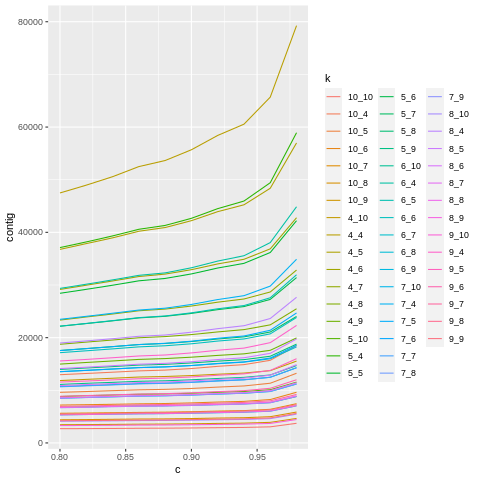

In [59]:
%%R
library(readr)
library(ggplot2)

kopt <- read_table2('kopt.data',col_names = c('k1','k2','c','contig'))
kopt$k <- paste0(kopt$k1,'_',kopt$k2)

ggplot(data=kopt,aes(x=c,y=contig,colour=k)) + 
  geom_line() 

c = .96 is the winner!, look where it starts to tick up

# MapOpt now!!!
    This script assembles references across cutoff values and then maps 20 random samples and evaluates mappings to the reference, along with number of contigs and coverage.
    
    Moves fastq files from refOpt, runs dDocent to get trimmed files
    
    choose mapOpt sim from kopt above: 96 add (e.g. 92,94,96,98)

In [60]:
cd $assembly_dir

/data/gpfs/assoc/denovo/PHHA/assembly


In [61]:
!mkdir mapOpt

mkdir: cannot create directory ‘mapOpt’: File exists


In [79]:
mapOpt_dir = os.path.join(assembly_dir,'mapOpt')
assert mapOpt_dir

In [63]:
sim_val = [92,94,96,98]

In [64]:
for sim in sim_val:
    mapsim = "mapOpt/mapOpt%d" % (sim)
    !mkdir $mapsim

In [65]:
### cp fastq from refOpt
fq_files = !find $refOpt_dir -name '*fq.gz'
fq_files = [os.path.abspath(x) for x in fq_files]
len(fq_files),fq_files[0]

(52, '/data/gpfs/assoc/denovo/PHHA/assembly/refOpt/PH_DA_7.F.fq.gz')

In [66]:
for fq in fq_files:   
    for sim in sim_val:
        mapsim = "mapOpt/mapOpt%d" % (sim)
        !cp $fq $mapsim

In [67]:
for sim in sim_val:
    mapsim = "mapOpt/mapOpt%d" % (sim)
    logfiles = os.path.join(refOpt_dir,'logfiles')
    !cp -r $logfiles $mapsim

In [68]:
src_dir = '/data/gpfs/assoc/denovo/src/refOpt/./'
mapOpt_sh = []
for sim in sim_val:
    sh = src_dir + "Map%d.sh"%(sim)
    mapOpt_sh.append(sh)

In [69]:
len(mapOpt_sh), mapOpt_sh

(4,
 ['/data/gpfs/assoc/denovo/src/refOpt/./Map92.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map94.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map96.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map98.sh'])

In [70]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4 days
cpus = 16
mem_cpu = 2500

#RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 

In [71]:
cd $mapOpt_dir

/data/gpfs/assoc/denovo/PHHA/assembly/mapOpt


In [82]:
def write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,mapOpt_dir,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("mapOpt%d/run_mapOpt%d.sh" % (sim,sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name mapOpt%d
#SBATCH --output output_mapOpt%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

cd %s/mapOpt%d\n\n""" % (account,partition,time,int(cpus),int(mem_cpu),sim,sim,email,mapOpt_dir,sim))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d 0.%d %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,cpus))

In [83]:
write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,mapOpt_dir,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type)

In [74]:
mapShells = !find $mapOpt_dir -name 'run_map*.sh'
mapShells

['/data/gpfs/assoc/denovo/PHHA/assembly/mapOpt/mapOpt94/run_mapOpt94.sh',
 '/data/gpfs/assoc/denovo/PHHA/assembly/mapOpt/mapOpt96/run_mapOpt96.sh',
 '/data/gpfs/assoc/denovo/PHHA/assembly/mapOpt/mapOpt92/run_mapOpt92.sh',
 '/data/gpfs/assoc/denovo/PHHA/assembly/mapOpt/mapOpt98/run_mapOpt98.sh']

In [75]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [76]:
write_sbatch_mapOpt(mapShells)

# Run all mapOpt*sh ()
    cd /data/gpfs/assoc/denovo/PHHA/assembly/mapOpt
    source activate ddocent_env
    bash sbatch_mapOpt.sh

# Read in mapping results and make decision

In [84]:
cd $root

/data/gpfs/assoc/denovo/PHHA


In [85]:
mapResults = !find . -name 'mapping*results'
mapResults

['./assembly/mapOpt/mapOpt94/mapping94.results',
 './assembly/mapOpt/mapOpt96/mapping96.results',
 './assembly/mapOpt/mapOpt92/mapping92.results',
 './assembly/mapOpt/mapOpt98/mapping98.results']

In [86]:
for mR in mapResults:
    print(mR)
    !cat $mR
    print('\n')

./assembly/mapOpt/mapOpt94/mapping94.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
33.9488	40.3313	60545	51111.9	4	4	39053860	0	2.05547e+06	0	0
43.221	49.4885	45232	39592.1	4	5	37145271	0	1.95501e+06	0	0
53.5678	59.964	34882	31218.3	4	6	35503529	0	1.86861e+06	0	0
65.5262	72.1894	27341	24855.3	4	7	34040724	0	1.79162e+06	0	0
79.8347	87.018	21524	19773.1	4	8	32650384	0	1.71844e+06	0	0
97.6282	105.391	16923	15693.8	4	9	31392976	0	1.65226e+06	0	0
120.144	128.9	13268	12378.6	4	10	30289739	0	1.5942e+06	0	0
42.9012	49.4435	45946	39959.4	5	4	37452492	0	1.97118e+06	0	0
54.8918	61.4604	34109	30519.6	5	5	35574846	0	1.87236e+06	0	0
69.0053	75.838	25901	23602.6	5	6	33960126	0	1.78738e+06	0	0
85.1541	92.339	20146	18602.7	5	7	32596363	0	1.7156e+06	0	0
104.06	112.024	15823	14714.9	5	8	31286255	0	1646645	0	0
127.448	136.193	12455	11666.8	5	9	30162422	0	1.5875e+06	0	0
156.993	166.619	9772	9215.26	5	10	29151505	0	1.53429e+06	0	0
53.1653	60



./assembly/mapOpt/mapOpt98/mapping98.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
21.382	26.3231	79261	64652.6	4	4	32200895	0	1.69478e+06	0	0
30.2457	35.298	56980	48919.6	4	5	32745216	0	1.72343e+06	0	0
39.2414	44.3343	42780	37909.1	4	6	31896894	0	1.67878e+06	0	0
49.5239	54.7175	32839	29743.7	4	7	30900900	0	1.62636e+06	0	0
61.3878	66.8898	25487	23403.2	4	8	29728384	0	1.56465e+06	0	0
75.3396	81.1266	19948	18531.6	4	9	28556042	0	1.50295e+06	0	0
92.7485	99.1699	15551	14548.4	4	10	27406075	0	1442425	0	0
29.4721	34.8834	58922	49888.4	5	4	32995110	0	1.73658e+06	0	0
39.9919	45.3801	42214	37243.4	5	5	32076936	0	1.68826e+06	0	0
51.5581	57.0046	31411	28431.2	5	6	30771335	0	1.61954e+06	0	0
64.9992	70.5766	24026	22138.2	5	7	29672990	0	1.56174e+06	0	0
79.7481	85.7712	18770	17458.3	5	8	28442069	0	1496951	0	0
97.7259	104.134	14700	13798.9	5	9	27296702	0	1.43667e+06	0	0
119.746	126.636	11548	10921.8	5	10	26275903	0	1.38294e+06	0	0
37

In [90]:
%%R 
library(readr)
library(data.table)
setwd('/data/gpfs/assoc/denovo/PHHA/assembly/mapOpt')

mapping92 <- read_table2('mapOpt92/mapping92.results')
mapping92$k <- paste0(mapping92$K1,'_',mapping92$K2)
mapping92$sim <- '92'
mapping92$ratio <- abs( scale(mapping92$SUM_1) / (scale(mapping92$MeanContigsMapped) / scale(mapping92$Cov) ) ) 


mapping94 <- read_table2('mapOpt94/mapping94.results')
mapping94$k <- paste0(mapping94$K1,'_',mapping94$K2)
mapping94$sim <- '94'
mapping94$ratio <- abs( scale(mapping94$SUM_1) / (scale(mapping94$MeanContigsMapped) / scale(mapping94$Cov) ) ) 

mapping96 <- read_table2('mapOpt96/mapping96.results')
mapping96$k <- paste0(mapping96$K1,'_',mapping96$K2)
mapping96$sim <- '96'
mapping96$ratio <- abs( scale(mapping96$SUM_1) / (scale(mapping96$MeanContigsMapped) / scale(mapping96$Cov) ) )

mapping98 <- read_table2('mapOpt98/mapping98.results')
mapping98$k <- paste0(mapping98$K1,'_',mapping98$K2)
mapping98$sim <- '98'
mapping98$ratio <- abs( scale(mapping98$SUM_1) / (scale(mapping98$MeanContigsMapped) / scale(mapping98$Cov) ) ) 

#print(mapping92)
#print(mapping94)
#print(mapping96)

#map_df
map_df <- rbindlist(list(mapping98,mapping92,mapping94,mapping96))
head(map_df)

R[write to console]: 
── Column specification ─────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)


R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  2  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  3  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  4  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  5  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
... ... .......... .......... ............................
See problems(...) for more

       Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM Mapped   SUM_1
1: 21.3820 26.3231   79261           64652.6  4  4 32200895      0 1694780
2: 30.2457 35.2980   56980           48919.6  4  5 32745216      0 1723430
3: 39.2414 44.3343   42780           37909.1  4  6 31896894      0 1678780
4: 49.5239 54.7175   32839           29743.7  4  7 30900900      0 1626360
5: 61.3878 66.8898   25487           23403.2  4  8 29728384      0 1564650
6: 75.3396 81.1266   19948           18531.6  4  9 28556042      0 1502950
   Properly Mean Mapped_1 Mean_1 Properly_1 MisMatched   k sim     ratio
1:        0    0     <NA>   <NA>       <NA>       <NA> 4_4  98 0.6084148
2:        0    0     <NA>   <NA>       <NA>       <NA> 4_5  98 0.9363312
3:        0    0     <NA>   <NA>       <NA>       <NA> 4_6  98 1.0736614
4:        0    0     <NA>   <NA>       <NA>       <NA> 4_7  98 1.1847408
5:        0    0     <NA>   <NA>       <NA>       <NA> 4_8  98 1.2980595
6:        0    0     <NA>   <NA>     

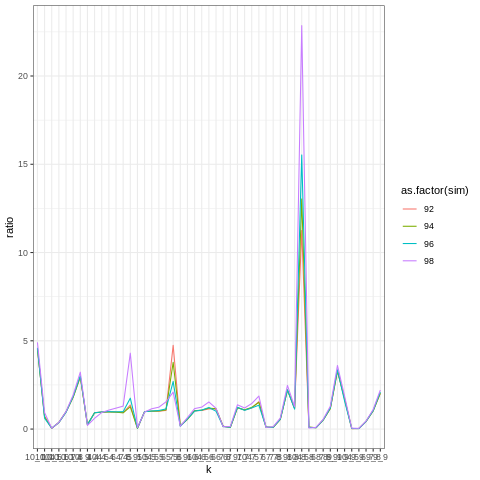

In [91]:
%%R
ggplot(data=map_df,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [51]:
%%R 
colMeans(map_df[,c(1:7,9)])

              Cov           Non0Cov           Contigs MeanContigsMapped 
     9.809895e+02      9.887925e+02      5.584474e+03      5.410035e+03 
               K1                K2               SUM             SUM_1 
     7.000000e+00      7.000000e+00      2.665343e+07      1.400922e+06 


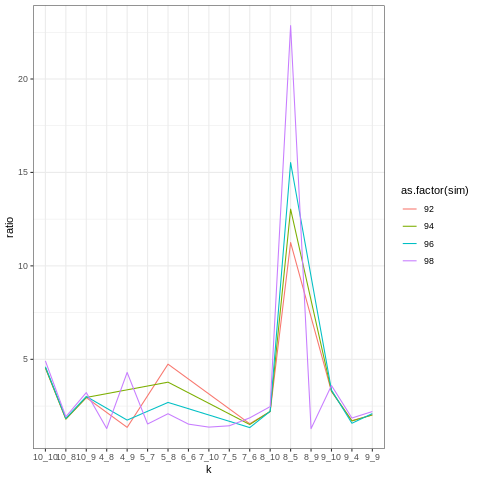

In [92]:
%%R
map_top <- map_df[which(map_df$ratio > quantile(map_df$ratio,probs=.75)),]

#SUM Properly
ggplot(data=map_top,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [93]:
%%R
names(map_df)

 [1] "Cov"               "Non0Cov"           "Contigs"          
 [4] "MeanContigsMapped" "K1"                "K2"               
 [7] "SUM"               "Mapped"            "SUM_1"            
[10] "Properly"          "Mean"              "Mapped_1"         
[13] "Mean_1"            "Properly_1"        "MisMatched"       
[16] "k"                 "sim"               "ratio"            


In [94]:
%%R
map_df[which(map_df$k %in% c('8_5')),c(1:7,9,17,18)]

        Cov  Non0Cov Contigs MeanContigsMapped K1 K2      SUM   SUM_1 sim
1:  76.5267  83.0589   19745           18200.3  8  5 28710841 1511100  98
2: 104.5070 112.3270   15840           14754.7  8  5 33109761 1655490  92
3: 103.1970 111.3550   16182           15015.2  8  5 31730674 1670040  94
4:  96.6233 104.5190   17024           15760.7  8  5 31255244 1645010  96
      ratio
1: 22.85427
2: 11.24839
3: 13.03421
4: 15.52691


# Map results 
    sim=98 K1=8 k2=5 WINNER
    
    remake reference in fastq using these parameters. Move reference.fasta to assembly dir